In [93]:
import sklearn
import matplotlib.pyplot as plt
import pandas
from sklearn.cross_validation import train_test_split
import numpy
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from nltk.classify import MaxentClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from nltk.util import ngrams

[nltk_data] Downloading package stopwords to /home/nbuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import CSV File

In [94]:
Tweet= pandas.read_csv("Tweets.csv")
Tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [95]:
(len(Tweet)-Tweet.count())/len(Tweet)

tweet_id                        0.000000
airline_sentiment               0.000000
airline_sentiment_confidence    0.000000
negativereason                  0.373087
negativereason_confidence       0.281284
airline                         0.000000
airline_sentiment_gold          0.997268
name                            0.000000
negativereason_gold             0.997814
retweet_count                   0.000000
text                            0.000000
tweet_coord                     0.930396
tweet_created                   0.000000
tweet_location                  0.323292
user_timezone                   0.329235
dtype: float64

# Delete NaN Columns

In [96]:
del Tweet['tweet_coord']
del Tweet['airline_sentiment_gold']
del Tweet['negativereason_gold']

In [97]:
Mood_count=Tweet['airline_sentiment'].value_counts()

# Plot of Mood_count

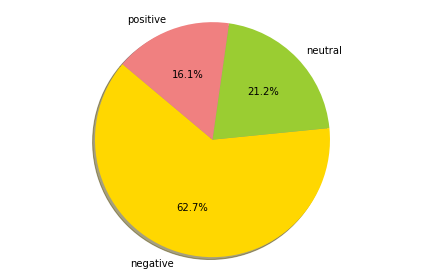

In [98]:
labels = 'negative', 'neutral', 'positive'
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(Mood_count, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

In [99]:
Tweet['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

# Plot of Mood_Count of Various Regions

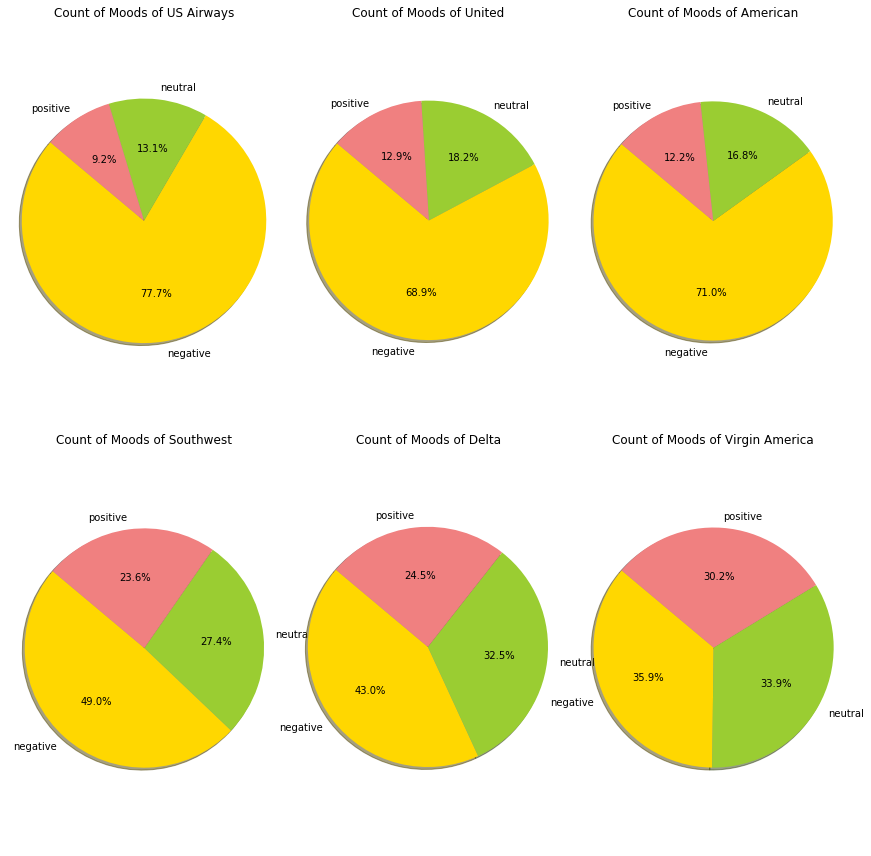

In [100]:
def plot_sub_sentiment(Airline):
    df=Tweet[Tweet['airline']==Airline]
    count=df['airline_sentiment'].value_counts()
    labels = 'negative', 'neutral', 'positive'
    colors = ['gold', 'yellowgreen', 'lightcoral']
    explode = (0,0,0)  # explode 1st slice
 
    # Plot
    plt.pie(count, explode=explode, labels=labels, colors=colors,
    autopct='%1.1f%%', shadow=True, startangle=140)
 
    plt.axis('equal')
    plt.tight_layout()
    plt.title('Count of Moods of '+Airline)
plt.figure(1,figsize=(12, 12))
plt.subplot(231)
plot_sub_sentiment('US Airways')
plt.subplot(232)
plot_sub_sentiment('United')
plt.subplot(233)
plot_sub_sentiment('American')
plt.subplot(234)
plot_sub_sentiment('Southwest')
plt.subplot(235)
plot_sub_sentiment('Delta')
plt.subplot(236)
plot_sub_sentiment('Virgin America')

# Plot of All Negative Mood_Counts

In [101]:
NR_Count=dict(Tweet['negativereason'].value_counts(sort=False))

In [102]:
def NR_Count(Airline):
    if Airline=='All':
        df=Tweet
    else:
        df=Tweet[Tweet['airline']==Airline]
    count=dict(df['negativereason'].value_counts())
    Unique_reason=list(Tweet['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pandas.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame

In [103]:
def plot_reason(Airline):
    df=NR_Count(Airline)
    count=df['count']
    Index = range(1,(len(df)+1))
    plt.bar(Index,count)
    plt.xticks(Index,df['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)

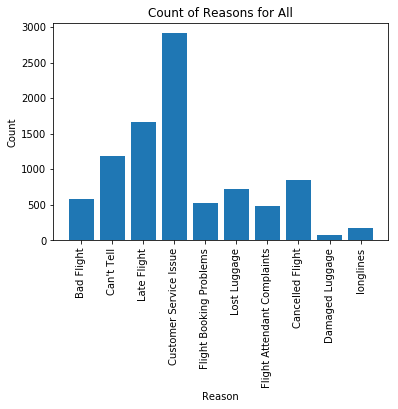

In [104]:
plot_reason('All')

This Function keeps text only and remove number, punctuation, stopwords

In [105]:
def tweet_to_words(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet)
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 


This Function count Number of words in clean tweet

In [106]:
def clean_tweet_length(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(len(meaningful_words)) 



# Addition Of Column Sentiment


In [107]:
Tweet['sentiment']=Tweet['airline_sentiment'].apply(lambda x: 0 if x=='negative' else 1)

# Addition Of Column Clean_tweet
This column contains pre-processed text  

In [108]:
Tweet['clean_tweet']=Tweet['text'].apply(lambda x: tweet_to_words(x))

# Addition Of Column Tweet_length
This column contains number of words in clean tweet

In [109]:
Tweet['Tweet_length']=Tweet['text'].apply(lambda x: clean_tweet_length(x))
Tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,sentiment,clean_tweet,Tweet_length
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),1,virginamerica dhepburn said,3
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),1,virginamerica plus added commercials experienc...,6
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),1,virginamerica today must mean need take anothe...,8
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),0,virginamerica really aggressive blast obnoxiou...,11
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),0,virginamerica really big bad thing,5


# Split data into test and train data

In [110]:
train,test = train_test_split(Tweet,test_size=0.25,random_state=42)

In [111]:
train_clean_tweet=[]
for tweet in train['clean_tweet']:
    train_clean_tweet.append(tweet)
test_clean_tweet=[]
for tweet in test['clean_tweet']:
    test_clean_tweet.append(tweet)

# Converts a collection of text documents to a matrix of token counts

In [112]:
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_clean_tweet)
test_features=v.transform(test_clean_tweet)

# Classifiers 

In [113]:
Classifiers = [KNeighborsClassifier(3)]

# Training and Testing using respective classifiers

In [115]:
dense_test= test_features.toarray()
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features,train['sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features,train['sentiment'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(test['sentiment'],pred)
    Accuracy.append(accuracy)
    p,r,f,_=precision_recall_fscore_support(test['sentiment'],pred,average='macro')
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+'is '+str(accuracy))
    print('Precision:',p)
    print('Recall:',r)
    print('f1-score:',f)
    Test_Result=[accuracy,p,r,f]

Accuracy of KNeighborsClassifieris 0.6163934426229508
('Precision:', 0.6621487590646424)
('Recall:', 0.664500777000777)
('f1-score:', 0.6163328376694219)


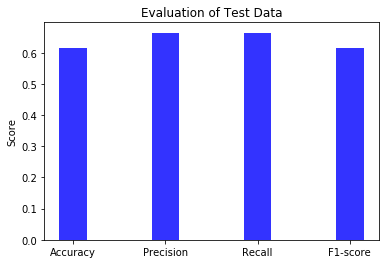

In [118]:
Objects= ('Accuracy','Precision','Recall','F1-score')
perform= Test_Result
bar_width=0.3
final_result_plot=plt.bar(Objects,perform,bar_width,alpha=0.8,color='b')
plt.xticks(Objects,Objects)
plt.ylabel('Score')
plt.title('Evaluation of Test Data')
plt.show()
